# 1. Load libraries and data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

In [4]:

# Read data
excel_file = r"C:\Users\Dell\Documents\(1) Neu\Big data\Cleaned_Insurance_Claims_Data.xlsx"
# Read individual sheets
claims_payments_df = pd.read_excel(excel_file, sheet_name='Claims Payments')
regions_df = pd.read_excel(excel_file, sheet_name='Regions')
state_regions_df = pd.read_excel(excel_file, sheet_name='State Regions')
policies_df = pd.read_excel(excel_file, sheet_name='Policies')
participants_df = pd.read_excel(excel_file, sheet_name='Participants')
brokers_df = pd.read_excel(excel_file, sheet_name='Brokers')
products_df = pd.read_excel(excel_file, sheet_name='Products')
claims_announcements_df = pd.read_excel(excel_file, sheet_name='Claims Announcements')
claims_reserves_df = pd.read_excel(excel_file, sheet_name='Claims Reserves')

# 2. Income analysis

## 2.1 Premium income by product type

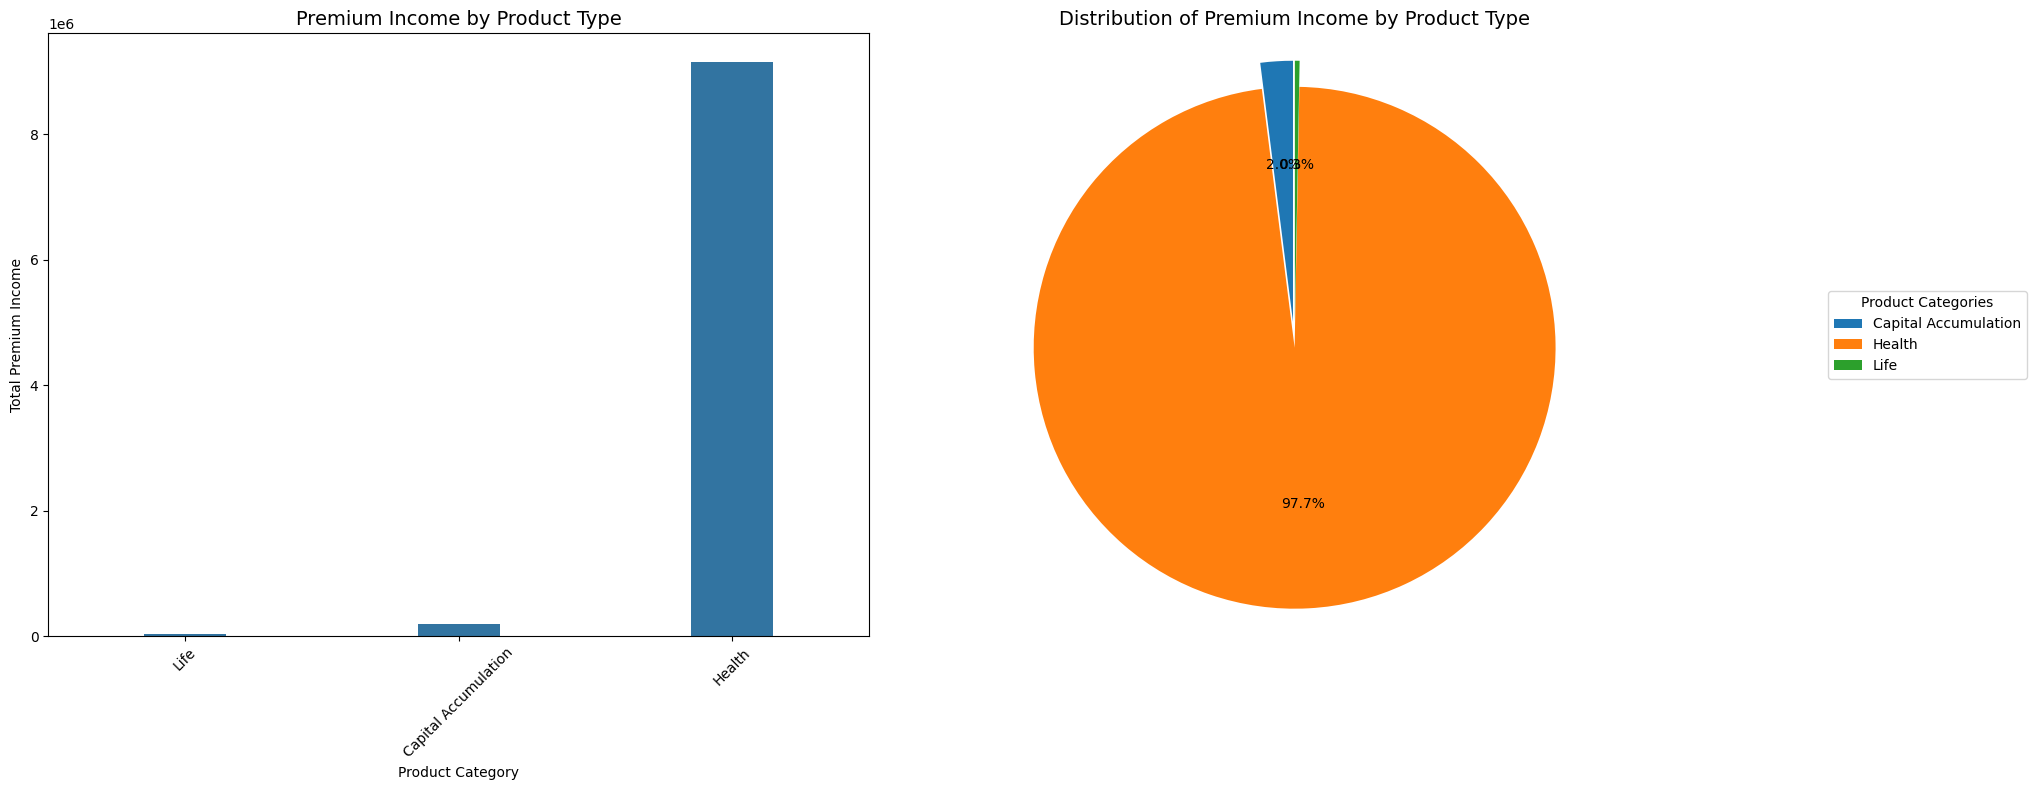

In [31]:
# Merge policies with products for product names
premium_by_product = pd.merge(policies_df, products_df, on='ProductID', how='left')

# Group by ProductCategory only to avoid duplicates
product_premium = premium_by_product.groupby('ProductCategory')['AnnualizedPolicyPremium'].sum().reset_index()

# Create a figure with two subplots side by side
plt.figure(figsize=(20, 8))

# Bar plot
plt.subplot(1, 2, 1)
# Reorder data to put highest premium category last
product_premium_reordered = product_premium.sort_values('AnnualizedPolicyPremium')
sns.barplot(data=product_premium_reordered, x='ProductCategory', y='AnnualizedPolicyPremium', errorbar=None, width=0.3)
plt.title('Premium Income by Product Type', fontsize=14)
plt.xlabel('Product Category')
plt.ylabel('Total Premium Income')
plt.xticks(rotation=45)

# Pie chart
plt.subplot(1, 2, 2)
# Calculate percentages for better labeling
sizes = product_premium['AnnualizedPolicyPremium']
categories = product_premium['ProductCategory']
total = sizes.sum()

# Create explode array to pull out smaller slices
explode = [0.1 if x < total*0.1 else 0 for x in sizes]  # Pull out slices less than 10%

# Create pie chart with better formatting
plt.pie(sizes, 
        labels=None,  # Remove direct labels
        explode=explode,
        autopct='%1.1f%%',
        shadow=False, 
        startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add a legend outside the pie
plt.legend(categories, title="Product Categories", loc="center right", bbox_to_anchor=(1.4, 0.5))
plt.title('Distribution of Premium Income by Product Type', fontsize=14)

plt.tight_layout()
plt.show()

## 2.2 Monthly Premium income over time

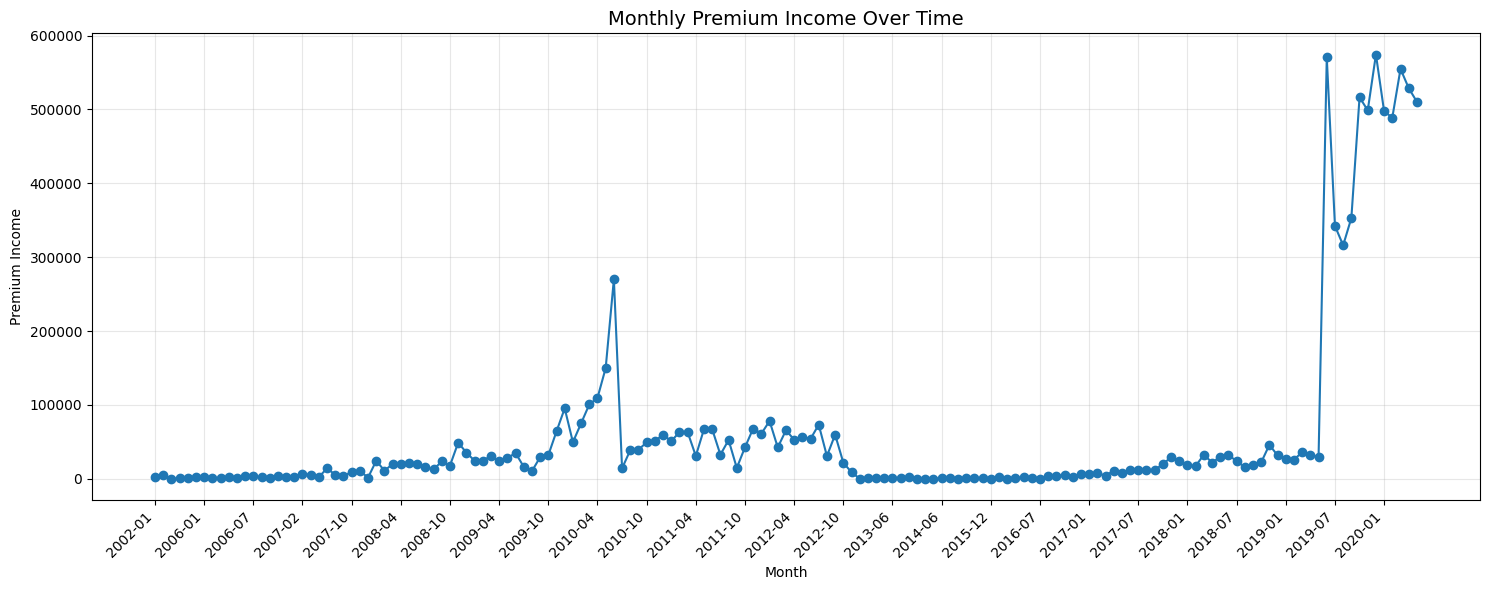

In [ ]:
# Convert PolicyStartDate to datetime if not already
policies_df['PolicyStartDate'] = pd.to_datetime(policies_df['PolicyStartDate'])

# Group by month
monthly_premium = policies_df.groupby(policies_df['PolicyStartDate'].dt.to_period('M'))['AnnualizedPolicyPremium'].sum()

plt.figure(figsize=(15, 6))
plt.plot(monthly_premium.index.astype(str), monthly_premium.values, marker='o')
plt.title('Monthly Premium income over time', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Premium income')

# Improve x-axis readability
# Get all x-tick positions
x_ticks = np.arange(len(monthly_premium.index))
# Show only every 6th month label
plt.xticks(x_ticks[::6], monthly_premium.index.astype(str)[::6], rotation=45, ha='right')

# Add gridlines for better readability
plt.grid(True, alpha=0.3)
# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# 3. Expenses analysis

## 3.1 Claims payments

### 3.1.1 Claims payments by product type

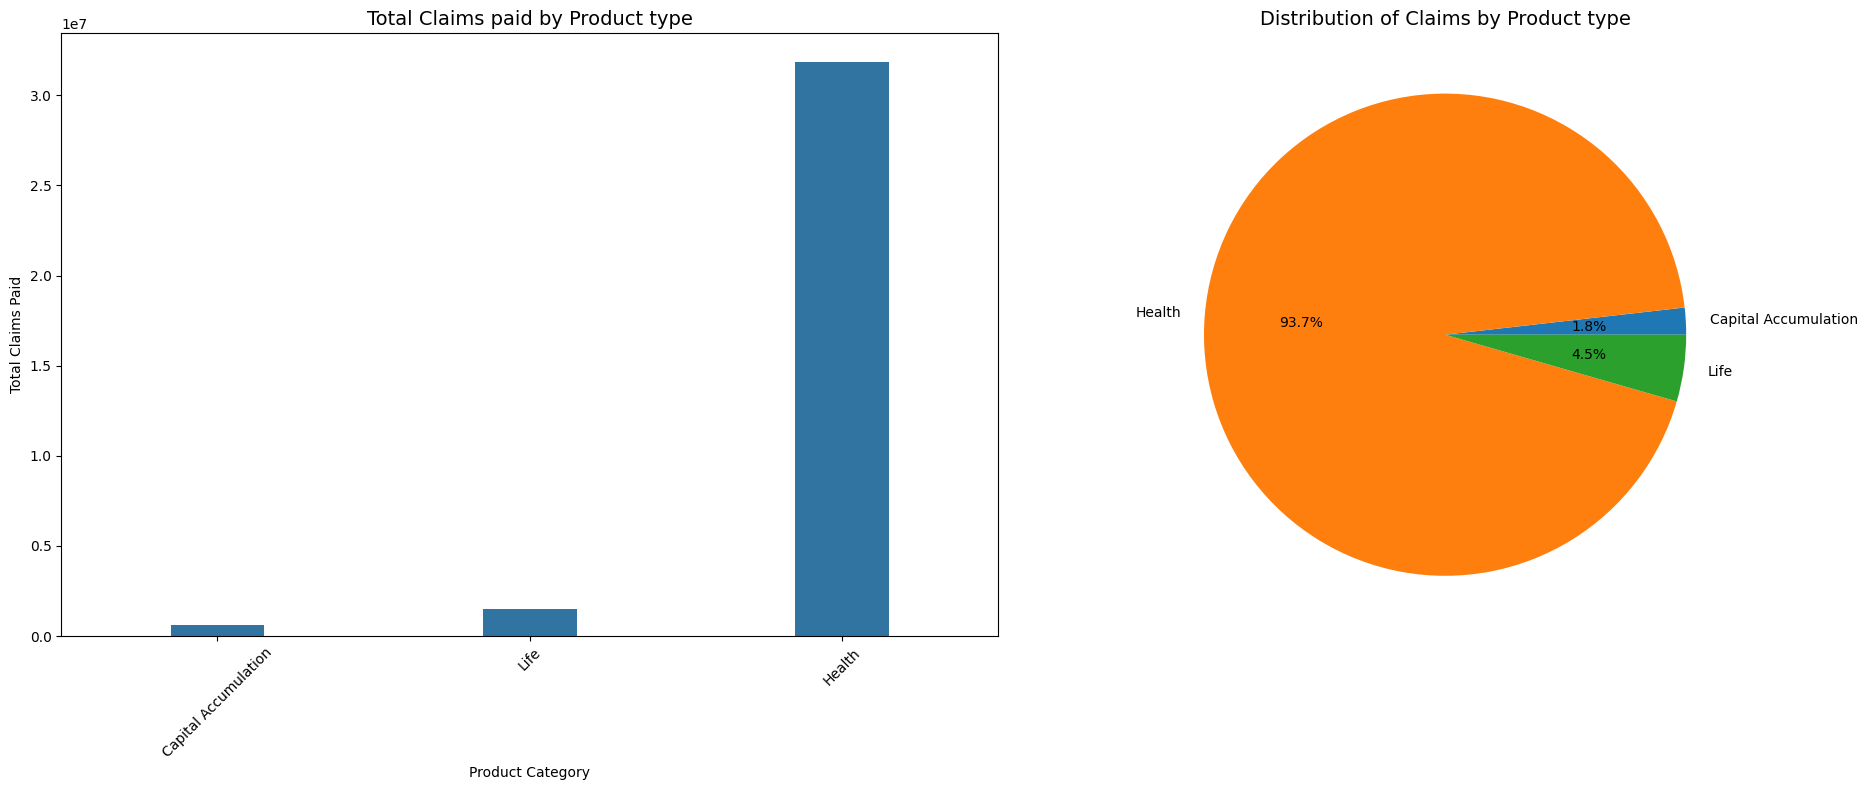

In [21]:
# Merge claims with products
claims_by_product = pd.merge(claims_payments_df, products_df, on='ProductID', how='left')
product_claims = claims_by_product.groupby('ProductCategory')['PaymentAmount'].sum().reset_index()

# Create a figure with two subplots side by side
plt.figure(figsize=(20, 8))

# Bar plot
plt.subplot(1, 2, 1)
# Reorder data to put health category last
product_claims_reordered = product_claims.loc[
    product_claims['ProductCategory'].isin(['Health']).argsort()
]
sns.barplot(data=product_claims_reordered, x='ProductCategory', y='PaymentAmount', width=0.3)
plt.title('Total Claims paid by Product type', fontsize=14)
plt.xlabel('Product Category')
plt.ylabel('Total Claims Paid')
plt.xticks(rotation=45)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(product_claims['PaymentAmount'], labels=product_claims['ProductCategory'], autopct='%1.1f%%')
plt.title('Distribution of Claims by Product type', fontsize=14)

plt.tight_layout()
plt.show()

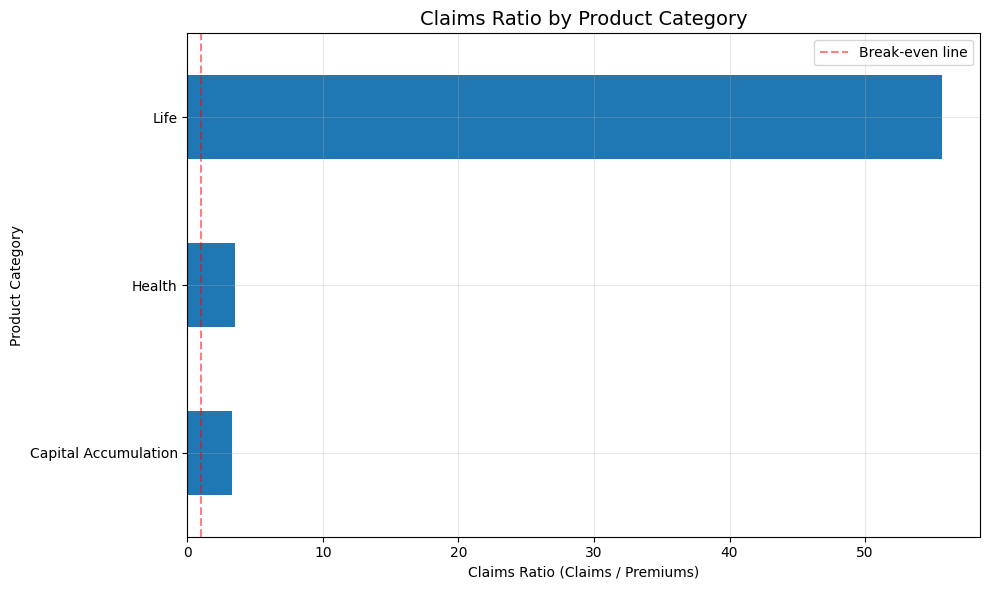


Claims Ratio Summary:
count     3.000
mean     20.812
std      30.213
min       3.256
25%       3.369
50%       3.481
75%      29.590
max      55.699
dtype: float64


In [7]:
# Merge product categories first
claims_with_category = pd.merge(claims_payments_df, products_df[['ProductID', 'ProductCategory']], on='ProductID', how='left')
policies_with_category = pd.merge(policies_df, products_df[['ProductID', 'ProductCategory']], on='ProductID', how='left')

# Calculate claims ratio by category
claims_by_category = claims_with_category.groupby('ProductCategory')['PaymentAmount'].sum()
premium_by_category = policies_with_category.groupby('ProductCategory')['AnnualizedPolicyPremium'].sum()
claims_ratio = (claims_by_category / premium_by_category).sort_values()

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
claims_ratio.plot(kind='barh')
plt.title('Claims Ratio by Product Category', fontsize=14)
plt.xlabel('Claims Ratio (Claims / Premiums)')
plt.ylabel('Product Category')
plt.axvline(x=1, color='r', linestyle='--', alpha=0.5, label='Break-even line')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nClaims Ratio Summary:")
print(claims_ratio.describe().round(3))

### 3.1.2 Geographical distribution of claims

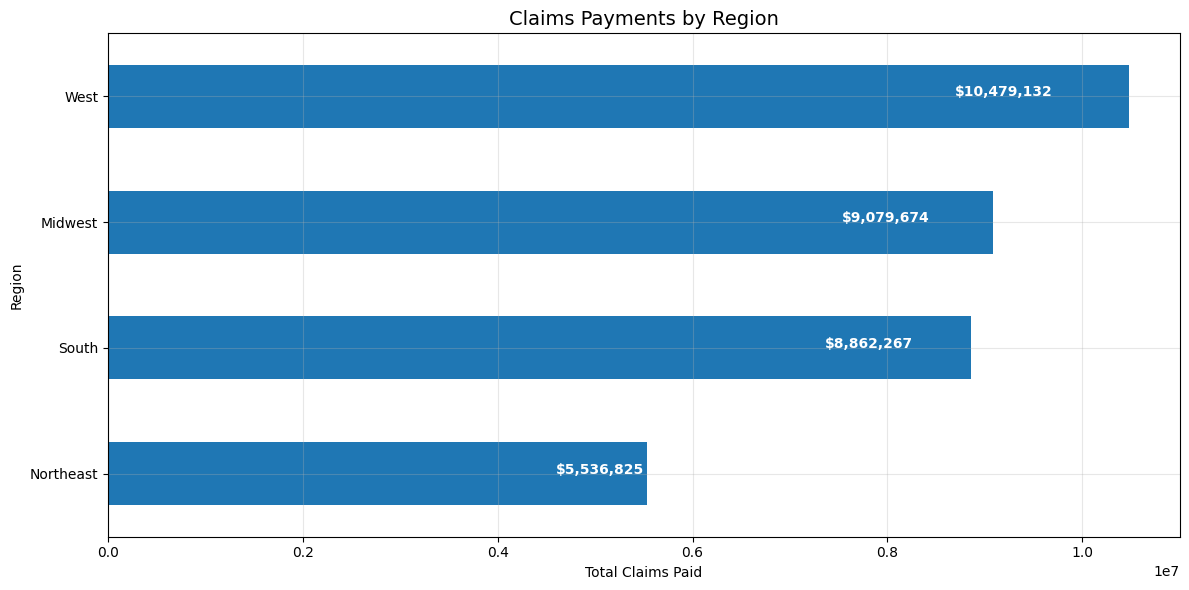


Regional Claims Summary:
          PaymentAmount                       ClaimID
                  count          sum     mean   count
Region                                               
Midwest            7154   9079674.01  1269.17    7154
Northeast          4596   5536824.76  1204.71    4596
South              7417   8862266.80  1194.86    7417
West               9059  10479132.20  1156.76    9059


In [18]:
# Create bridge from Claims to Regions using Participants and State Regions
claims_regional = (claims_payments_df
    # Connect claims to participants using InsuredID
    .merge(participants_df[['ParticipantID', 'RegionID']], 
           left_on='InsuredID', 
           right_on='ParticipantID', 
           how='left')
    # Connect to regions table
    .merge(regions_df[['id', 'state_code']], 
           left_on='RegionID',
           right_on='id', 
           how='left')
    # Finally connect to state regions for regional grouping
    .merge(state_regions_df[['State Code', 'Region']], 
           left_on='state_code',
           right_on='State Code', 
           how='left')
)

# Create regional analysis
regional_claims = claims_regional.groupby('Region')['PaymentAmount'].sum().sort_values(ascending=True)

# Visualize regional distribution
plt.figure(figsize=(12, 6))
ax = regional_claims.plot(kind='barh')
# Add values inside the bars
for index, value in enumerate(regional_claims):
    plt.text(value - (value * 0.17), index, f'${value:,.0f}', color='white', fontsize=10, weight='bold')

plt.title('Claims Payments by Region', fontsize=14)
plt.xlabel('Total Claims Paid')
plt.ylabel('Region')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nRegional Claims Summary:")
summary = claims_regional.groupby('Region').agg({
    'PaymentAmount': ['count', 'sum', 'mean'],
    'ClaimID': 'count'
}).round(2)
print(summary)

### 3.1.3 Claims payments calendar heatmap

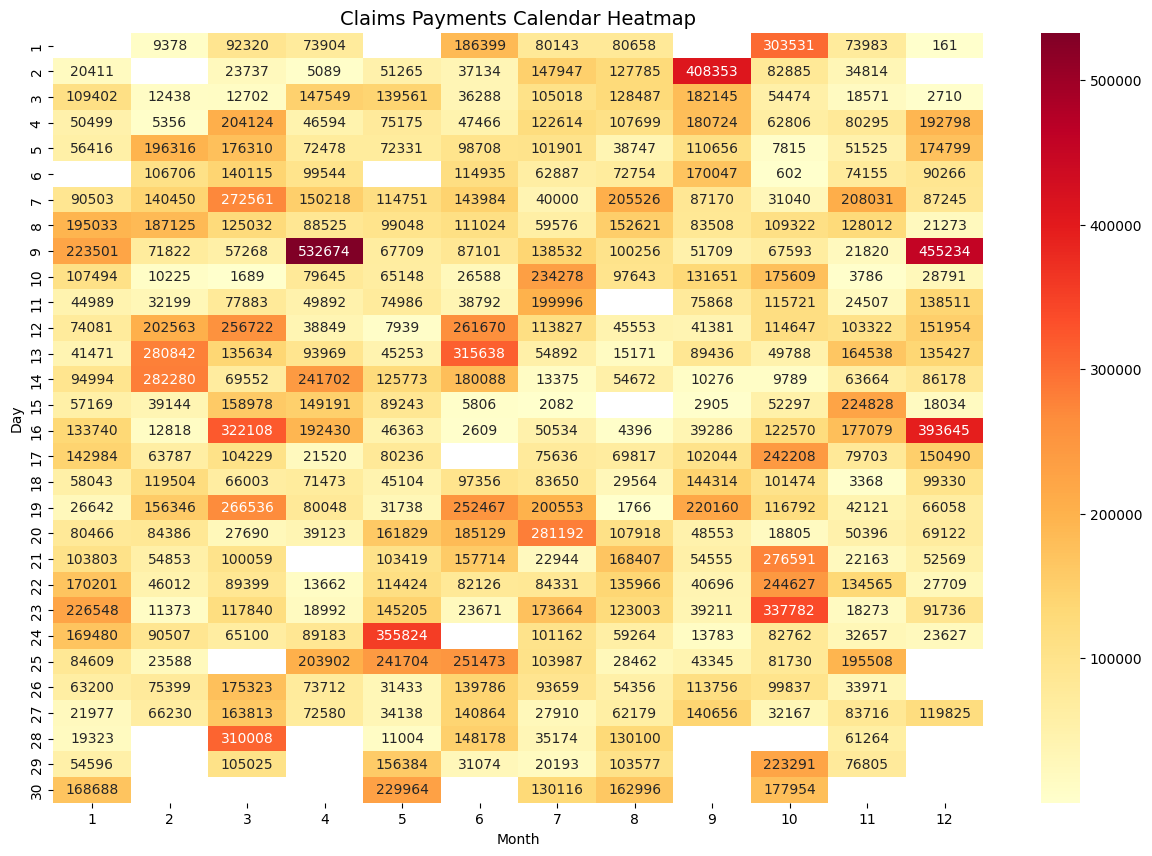

In [8]:
# Prepare daily claims data
claims_payments_df['PaymentDate'] = pd.to_datetime(claims_payments_df['PaymentDate'])
daily_claims = claims_payments_df.groupby('PaymentDate')['PaymentAmount'].sum().reset_index()

# Create calendar heatmap
daily_claims['Year'] = daily_claims['PaymentDate'].dt.year
daily_claims['Month'] = daily_claims['PaymentDate'].dt.month
daily_claims['Day'] = daily_claims['PaymentDate'].dt.day

pivot_table = daily_claims.pivot_table(index='Day', 
                                     columns='Month', 
                                     values='PaymentAmount', 
                                     aggfunc='sum')

plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Claims Payments Calendar Heatmap', fontsize=14)
plt.show()

### 3.1.4 Forecast accuracy

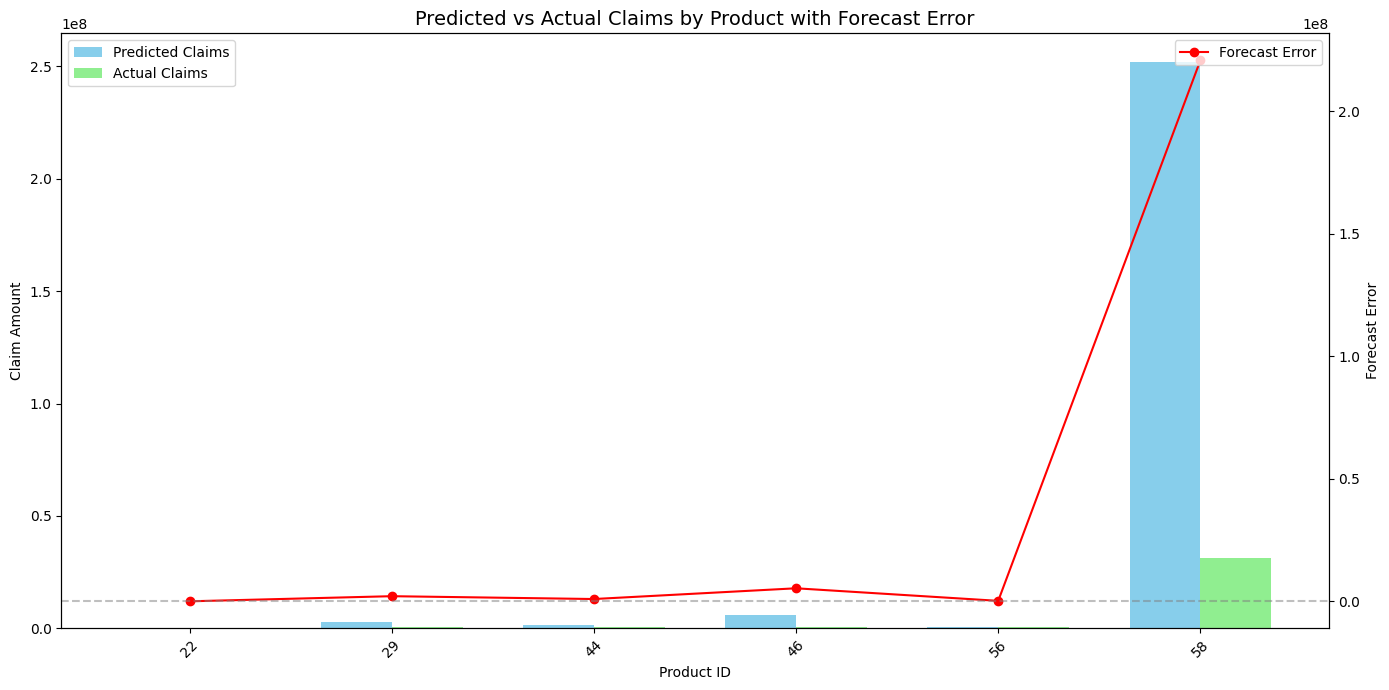

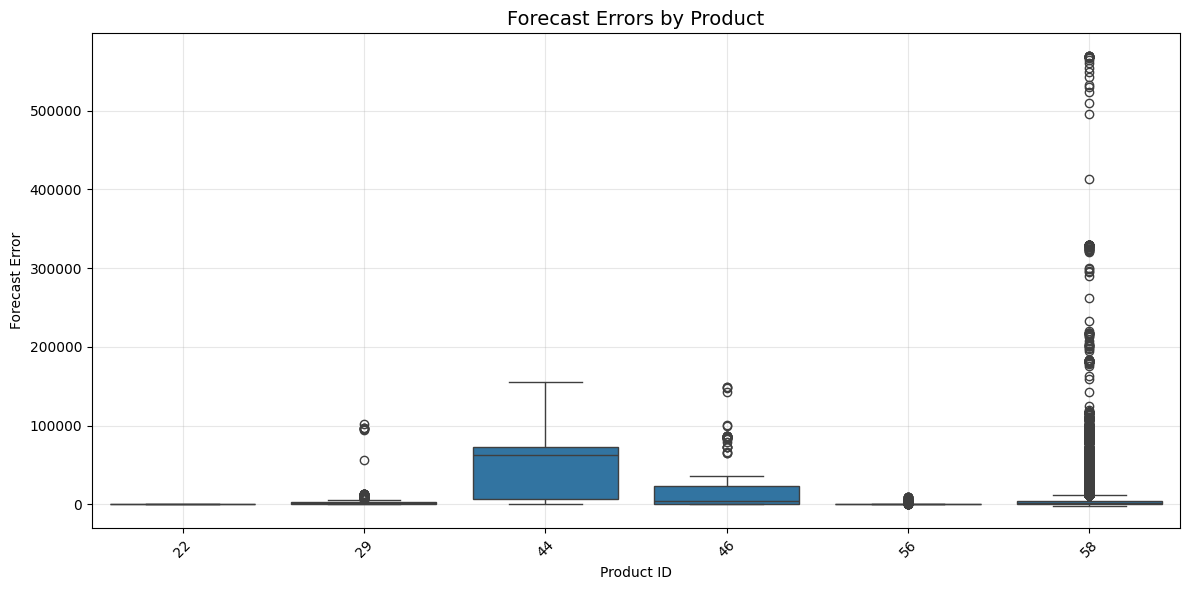

In [14]:
# Calculate forecast error
claims_with_forecast = pd.merge(claims_payments_df, claims_announcements_df[['ClaimID', 'LastForecastAmount']], 
                              on='ClaimID', how='left')
claims_with_forecast['ForecastError'] = claims_with_forecast['LastForecastAmount'] - claims_with_forecast['PaymentAmount']

# Group by ProductID for the grouped bar chart
product_comparison = claims_with_forecast.groupby('ProductID').agg({
    'LastForecastAmount': 'sum',
    'PaymentAmount': 'sum',
    'ForecastError': 'sum'
}).reset_index()

# Create grouped bar chart with error line
fig, ax1 = plt.figure(figsize=(14, 7)), plt.gca()

# Set the positions and width for the bars
x = np.arange(len(product_comparison))
width = 0.35

# Create bars
bars1 = ax1.bar(x - width/2, product_comparison['LastForecastAmount'], width, label='Predicted Claims', color='skyblue')
bars2 = ax1.bar(x + width/2, product_comparison['PaymentAmount'], width, label='Actual Claims', color='lightgreen')

# Create a secondary y-axis for the error line
ax2 = ax1.twinx()
ax2.plot(x, product_comparison['ForecastError'], 'ro-', label='Forecast Error')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Add labels, title and legend
ax1.set_xlabel('Product ID')
ax1.set_ylabel('Claim Amount')
ax2.set_ylabel('Forecast Error')
ax1.set_title('Predicted vs Actual Claims by Product with Forecast Error', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(product_comparison['ProductID'], rotation=45)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Create boxplot by product
plt.figure(figsize=(12, 6))
sns.boxplot(data=claims_with_forecast, x='ProductID', y='ForecastError')
plt.title('Forecast Errors by Product', fontsize=14)
plt.xlabel('Product ID')
plt.ylabel('Forecast Error')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3.2 Comissions

# 4. Reserves

## 4.1 Claims paid vs Reserves by year

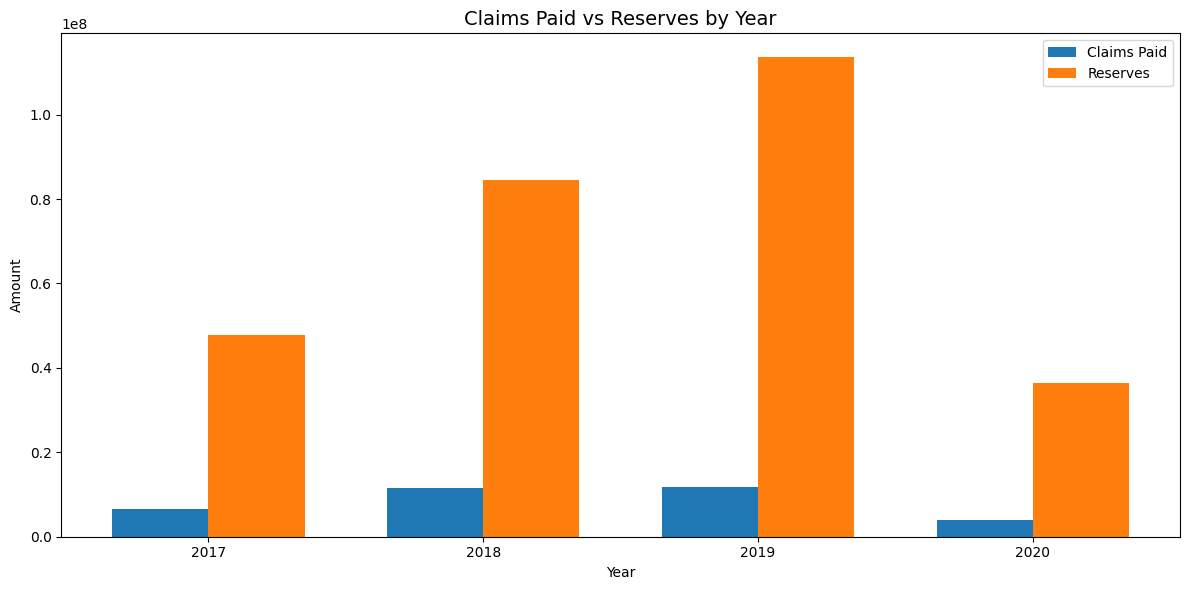

In [15]:
# Convert dates to datetime
claims_payments_df['PaymentDate'] = pd.to_datetime(claims_payments_df['PaymentDate'])
claims_reserves_df['ProvisionDate'] = pd.to_datetime(claims_reserves_df['ProvisionDate'])

# Aggregate by year
yearly_claims = claims_payments_df.groupby(claims_payments_df['PaymentDate'].dt.year)['PaymentAmount'].sum()
yearly_reserves = claims_reserves_df.groupby(claims_reserves_df['ProvisionDate'].dt.year)['ProvisionAmount'].sum()

# Create grouped bar chart
x = np.arange(len(yearly_claims.index))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, yearly_claims, width, label='Claims Paid')
ax.bar(x + width/2, yearly_reserves, width, label='Reserves')

plt.title('Claims Paid vs Reserves by Year', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Amount')
plt.xticks(x, yearly_claims.index)
plt.legend()
plt.tight_layout()
plt.show()

# Pairplot

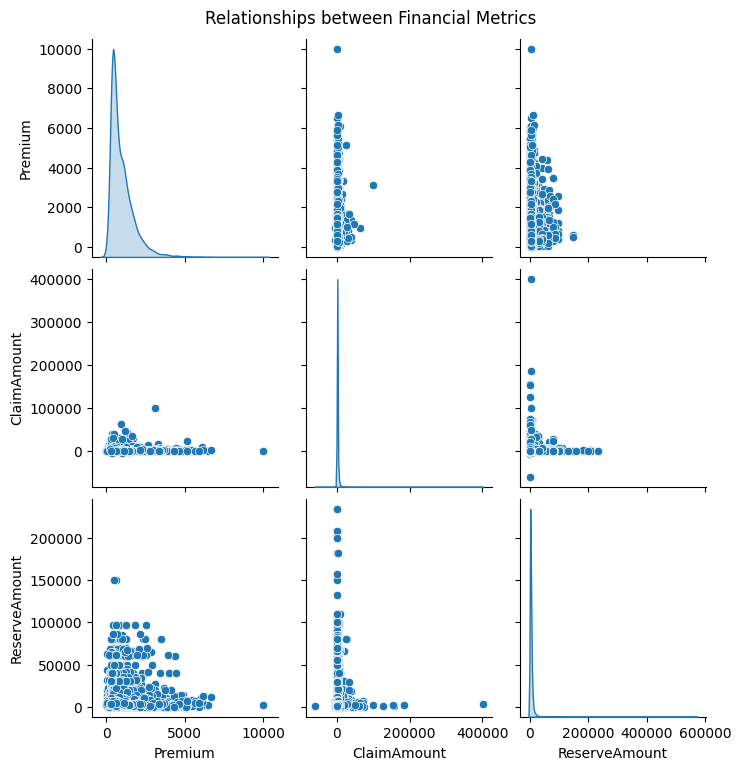

In [ ]:
# Prepare data for pairplot
numeric_data = pd.DataFrame({
    'Premium': policies_df['AnnualizedPolicyPremium'],
    'ClaimAmount': claims_payments_df['PaymentAmount'],
    'ReserveAmount': claims_reserves_df['ProvisionAmount']
})

# Create pairplot
sns.pairplot(numeric_data, diag_kind='kde')
plt.suptitle('Relationships between Financial Metrics', y=1.02)
plt.show()

# 5. Profitability

## 5.1 Net income calculation

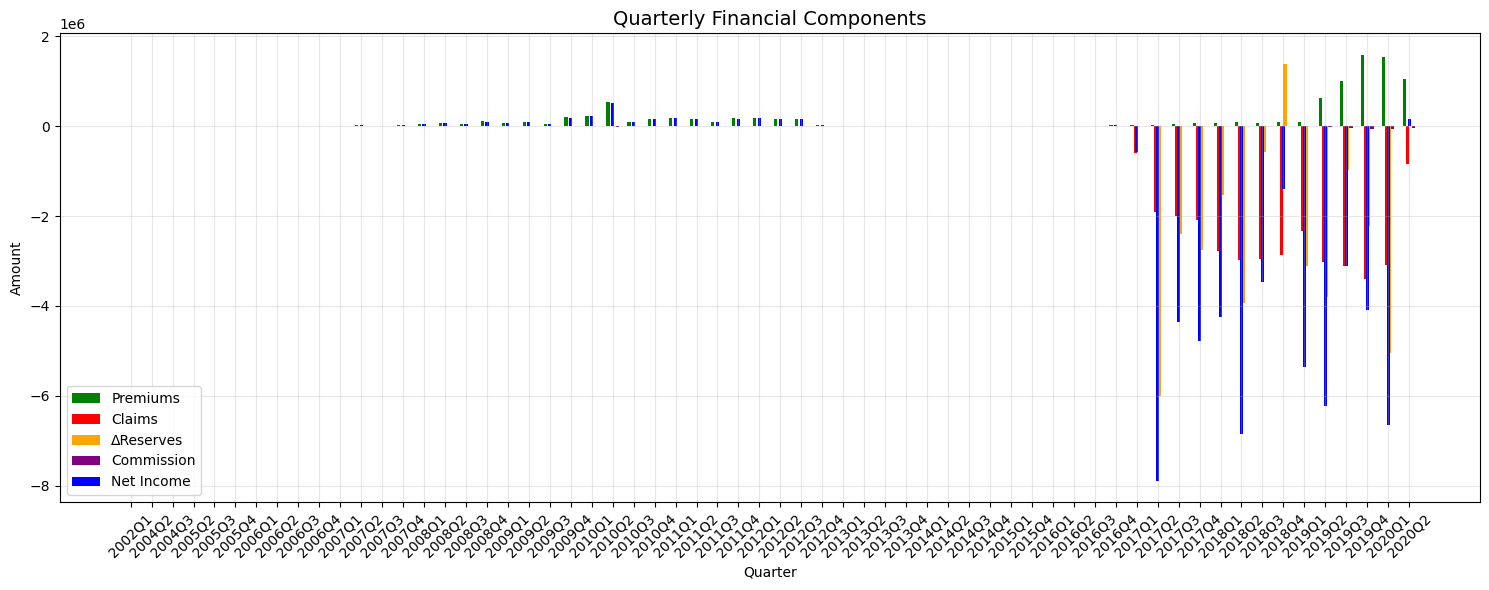

In [ ]:
# Convert dates to datetime
policies_df['PolicyStartDate'] = pd.to_datetime(policies_df['PolicyStartDate'])
claims_payments_df['PaymentDate'] = pd.to_datetime(claims_payments_df['PaymentDate'])
claims_reserves_df['ProvisionDate'] = pd.to_datetime(claims_reserves_df['ProvisionDate'])

# Calculate quarterly components
quarterly_premiums = policies_df.groupby(policies_df['PolicyStartDate'].dt.to_period('Q'))['AnnualizedPolicyPremium'].sum()
quarterly_claims = claims_payments_df.groupby(claims_payments_df['PaymentDate'].dt.to_period('Q'))['PaymentAmount'].sum()
quarterly_reserves = claims_reserves_df.groupby(claims_reserves_df['ProvisionDate'].dt.to_period('Q'))['ProvisionAmount'].sum()

# Create commission rate mapping
commission_rates = {
    'Comm-2': 0.02,
    'Comm-3': 0.03,
    'Comm-4': 0.04,
    'Comm-5': 0.05,
    'Comm-6': 0.06,
    'Comm-7': 0.07,
    'Comm-8': 0.08,
    'Comm-9': 0.09,
    'Bonus Based': 0.05,  # Assuming average bonus
    'No Commission': 0
}

# Add commission_rate column to brokers_df
brokers_df['commission_rate'] = brokers_df['CommissionScheme'].map(commission_rates)

# Calculate quarterly commission
policies_with_commission = pd.merge(policies_df, brokers_df[['BrokerID', 'commission_rate']], on='BrokerID', how='left')
quarterly_commission = policies_with_commission.groupby(policies_with_commission['PolicyStartDate'].dt.to_period('Q')).apply(
    lambda x: (x['AnnualizedPolicyPremium'] * x['commission_rate']).sum()
)

# Calculate quarterly net income
quarters = sorted(set(quarterly_premiums.index) | set(quarterly_claims.index) | set(quarterly_reserves.index))
quarterly_data = pd.DataFrame(index=quarters)
quarterly_data['Premiums'] = quarterly_premiums
quarterly_data['Claims'] = quarterly_claims
quarterly_data['Reserves'] = quarterly_reserves.diff()
quarterly_data['Commission'] = quarterly_commission
quarterly_data = quarterly_data.fillna(0)
quarterly_data['Net Income'] = (quarterly_data['Premiums'] - 
                              quarterly_data['Claims'] - 
                              quarterly_data['Reserves'] - 
                              quarterly_data['Commission'])

# Create grouped bar chart
plt.figure(figsize=(15, 6))
x = np.arange(len(quarters))
width = 0.15

plt.bar(x - width*1.5, quarterly_data['Premiums'], width, label='Premiums', color='green')
plt.bar(x - width/2, -quarterly_data['Claims'], width, label='Claims', color='red')
plt.bar(x + width/2, -quarterly_data['Reserves'], width, label='ΔReserves', color='orange')
plt.bar(x + width*1.5, -quarterly_data['Commission'], width, label='Commission', color='purple')
plt.bar(x, quarterly_data['Net Income'], width, label='Net Income', color='blue')

plt.title('Quarterly Financial Components', fontsize=14)
plt.xlabel('Quarter')
plt.ylabel('Amount')
plt.xticks(x, [str(q) for q in quarters], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5.2 Closer look at Net income in recent years

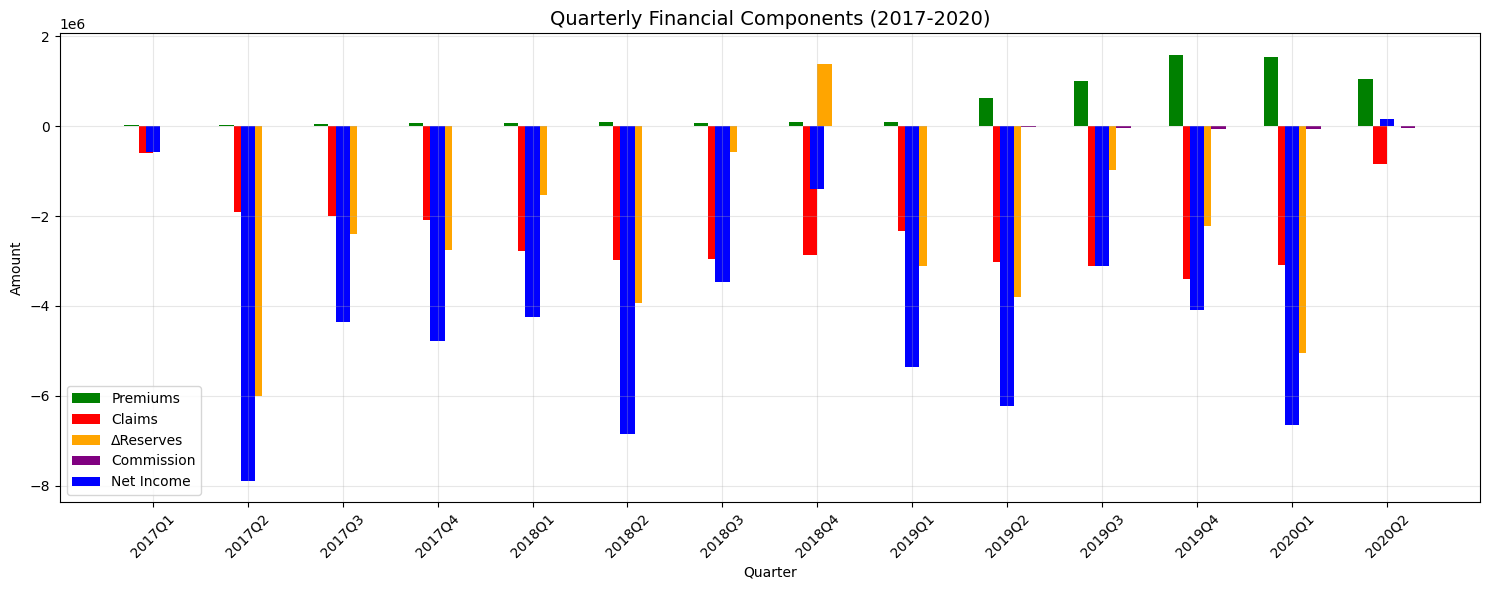


Quarterly Summary (2017-2020):
         Premiums      Claims    Reserves  Commission  Net Income
count       14.00       14.00       14.00       14.00       14.00
mean    455178.66  2426849.25  2212029.13    16888.34 -4200588.07
std     591323.79   856201.31  2081830.16    21962.70  2385192.81
min      18580.34   602749.21 -1372851.25      777.43 -7884882.68
25%      61304.56  2023735.46   670485.06     2276.93 -6009479.38
50%      86247.74  2818734.64  2305100.50     3155.24 -4304489.12
75%     916661.51  3020997.04  3631653.09    34657.82 -3202628.96
max    1589605.73  3402613.83  6009621.07    60140.19   158586.35


In [5]:
# Filter for recent years (2017-2020)
recent_quarters = [q for q in quarters if q.year >= 2017]
recent_data = quarterly_data.loc[recent_quarters]

# Create grouped bar chart for recent years
plt.figure(figsize=(15, 6))
x = np.arange(len(recent_quarters))
width = 0.15

plt.bar(x - width*1.5, recent_data['Premiums'], width, label='Premiums', color='green')
plt.bar(x - width/2, -recent_data['Claims'], width, label='Claims', color='red')
plt.bar(x + width/2, -recent_data['Reserves'], width, label='ΔReserves', color='orange')
plt.bar(x + width*1.5, -recent_data['Commission'], width, label='Commission', color='purple')
plt.bar(x, recent_data['Net Income'], width, label='Net Income', color='blue')

plt.title('Quarterly Financial Components (2017-2020)', fontsize=14)
plt.xlabel('Quarter')
plt.ylabel('Amount')
plt.xticks(x, [str(q) for q in recent_quarters], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics for recent years
print("\nQuarterly Summary (2017-2020):")
print(recent_data.describe().round(2))